In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# DATA AUGMENTATIONS
data_transforms = {
    'train': transforms.Compose([                   #Normalization for training
        transforms.Resize((256, 256)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([                     #Normalization for validation
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#Accessing dataset from Google Drive. Training data in 'train'. Validation data in 'val'
data_dir = '/content/drive/MyDrive/trainer_model'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

['Bangladesh', 'Maldives', 'Afghanistan', 'Bangladesh', 'Bhutan', 'India', 'Bangladesh', 'Maldives', 'India', 'India', 'Bhutan', 'Afghanistan', 'Bangladesh', 'India', 'Bhutan', 'Bhutan', 'Nepal', 'Maldives', 'Maldives', 'Pakistan', 'Pakistan', 'Bhutan', 'Afghanistan', 'Pakistan', 'Pakistan', 'Afghanistan', 'India', 'Pakistan', 'Nepal', 'Maldives', 'Bangladesh', 'Bangladesh', 'India', 'Bangladesh', 'Bhutan', 'Bhutan', 'Afghanistan', 'Maldives', 'Bangladesh', 'Nepal', 'Pakistan', 'Pakistan', 'Pakistan', 'Afghanistan', 'Sri Lanka', 'Bangladesh', 'Bangladesh', 'Maldives', 'Sri Lanka', 'India', 'Afghanistan', 'Pakistan', 'Bangladesh', 'Sri Lanka', 'Bhutan', 'Sri Lanka', 'Afghanistan', 'India', 'Bangladesh', 'Bangladesh', 'Bhutan', 'Maldives', 'Sri Lanka', 'Pakistan']


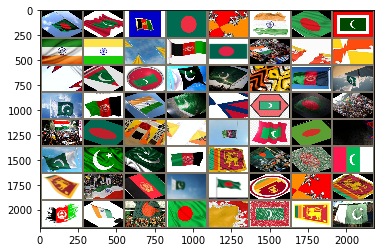

In [ ]:
#Function for visualizing a grid from a batch of training data.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) #limits the values in an array between 0 and 1
    plt.imshow(inp, interpolation='nearest', aspect='auto')
    plt.pause(0.001)  # pause a bit so all plots are updated


# Get a batch of training data for visualizaiton
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch of training data.
out = torchvision.utils.make_grid(inputs, padding=15)

title1=[class_names[x] for x in classes]
print(title1)
imshow(out, title=None)

In [ ]:
train_loss = list()
train_acc = list()
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) #recursively copies into a compund object of objects found in the original
    best_acc = 0.0
    best_acc1 = 0.0
    
    # val_loss = list()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            count = 1

            # Iterate over data. Inputs and labels to GPU
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward propogation
                # track history if only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward to calculate error
                    #optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # train_loss.append(running_loss)
            if phase == 'train':
                scheduler.step() #as we move down towards GD we want to slow down lr
            #Calculating loss and accuracy at each epoch
            epoch_loss = running_loss / dataset_sizes[phase]            
            epoch_acc = running_corrects.double() / dataset_sizes[phase]   
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)
  
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train' and epoch_acc > best_acc1:
                best_acc1 = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best train Acc: {:4f}'.format(best_acc1))
    #Best Validation Accuracy & Training Accuracy achieved over num_epochs epochs
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#Function for displaying model predictions. Displaying 10 predictions.
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()  

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)    #inputs to GPU
            labels = labels.to(device)    #labels to GPU

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

             #Display predicted class
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False         #freezing the parameters

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 8)    #8 output classes

model_conv = model_conv.to(device)   #model to GPU

criterion = nn.CrossEntropyLoss()    # Cross entropy loss function

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay Learning Rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
num_epochs = 20
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.1817 Acc: 0.6876
val Loss: 1.1402 Acc: 0.6808

Epoch 1/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4785 Acc: 0.9162
val Loss: 0.9237 Acc: 0.7041

Epoch 2/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.3119 Acc: 0.9515
val Loss: 0.8513 Acc: 0.7315

Epoch 3/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2315 Acc: 0.9647
val Loss: 0.8661 Acc: 0.7329

Epoch 4/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1874 Acc: 0.9724
val Loss: 0.8155 Acc: 0.7575

Epoch 5/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1569 Acc: 0.9791
val Loss: 0.8344 Acc: 0.7466

Epoch 6/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1260 Acc: 0.9839
val Loss: 0.7924 Acc: 0.7603

Epoch 7/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1162 Acc: 0.9850
val Loss: 0.7776 Acc: 0.7644

Epoch 8/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1087 Acc: 0.9906
val Loss: 0.7549 Acc: 0.7562

Epoch 9/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1077 Acc: 0.9899
val Loss: 0.7659 Acc: 0.7616

Epoch 10/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1062 Acc: 0.9881
val Loss: 0.7924 Acc: 0.7630

Epoch 11/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1067 Acc: 0.9902
val Loss: 0.7736 Acc: 0.7644

Epoch 12/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1082 Acc: 0.9874
val Loss: 0.7835 Acc: 0.7562

Epoch 13/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1050 Acc: 0.9885
val Loss: 0.7620 Acc: 0.7685

Epoch 14/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1009 Acc: 0.9909
val Loss: 0.7523 Acc: 0.7658

Epoch 15/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0982 Acc: 0.9906
val Loss: 0.7823 Acc: 0.7589

Epoch 16/19
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1004 Acc: 0.9913
val Loss: 0.7705 Acc: 0.7616

Epoch 17/19
----------


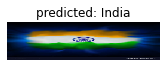

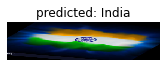

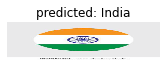

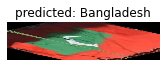

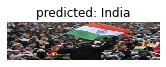

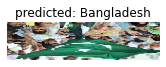

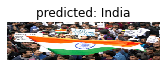

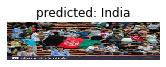

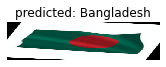

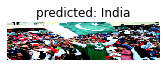

In [ ]:
visualize_model(model_conv)
#Displaying 10 model predictions
plt.ioff()
plt.show()

In [ ]:
j=0
total_val_loss = list()
while (j<=(num_epochs*2)):
  if j%2!=0:
    total_val_loss.append(train_loss[j])
  j+=1
# total_val_loss

a=0
total_val_acc = list()
while (a<=(num_epochs*2)):
  if a%2!=0:
    total_val_acc.append(train_acc[a])
  a+=1
# total_val_acc

b=0
total_train_acc = list()
while (b<=((num_epochs*2)-1)):
  if b%2==0:
    total_train_acc.append(train_acc[b])
  b+=1
# total_train_acc

i=1
total_train_loss = list()
total_train_loss.append(train_loss[0])
while (i<=((num_epochs*2)-1)):
  if i%2==0:
    total_train_loss.append(train_loss[i])
  i+=1
# total_train_loss

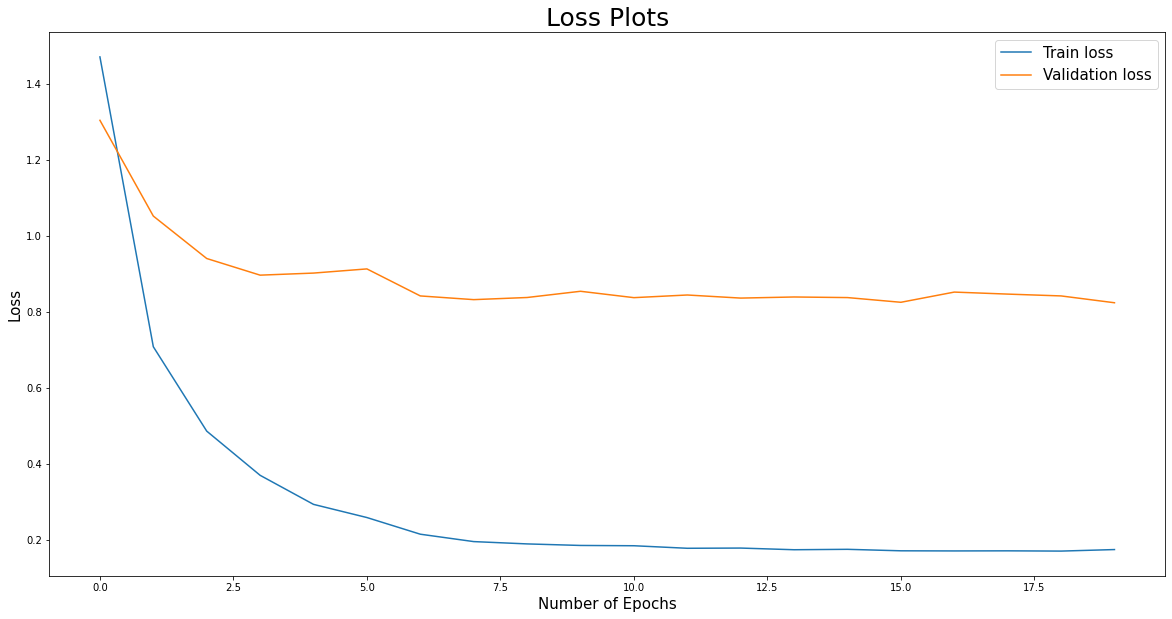

In [ ]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(0, num_epochs), total_train_loss, label="Train loss")
plt.plot(np.arange(0, num_epochs), total_val_loss, label="Validation loss")
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Number of Epochs', fontsize=15)
plt.title("Loss Plots", fontsize=25)
plt.legend(loc='best',prop={"size":15})
plt.show()

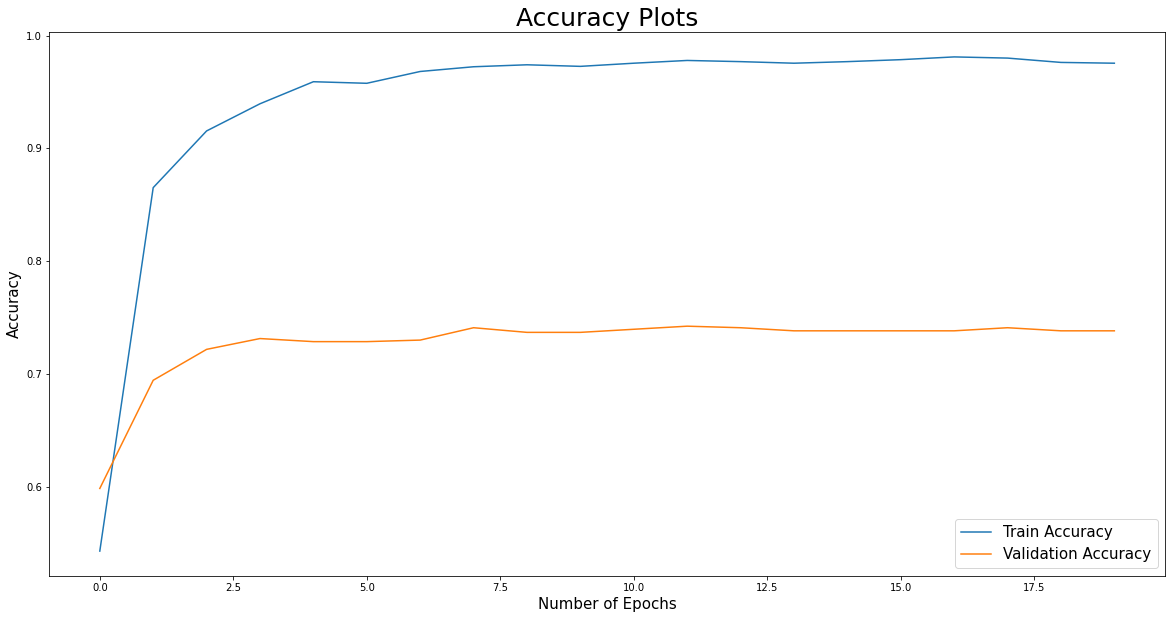

In [ ]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(0, num_epochs), total_train_acc, label="Train Accuracy")
plt.plot(np.arange(0, num_epochs), total_val_acc, label="Validation Accuracy")
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Number of Epochs', fontsize=15)
plt.title("Accuracy Plots", fontsize=25)
plt.legend(loc=4,prop={"size":15})
plt.show()

In [ ]:
# # !pip install myutils
# !pip install helper
# import helper
# import myutils
# path2vido = "/content/drive/MyDrive/augmented/SL.avi"
# # frames, v_len = myutils.get_frames(path2vido, n_frames=16)
# # len(frames), v_len
# path2vido

In [ ]:
# import cv2
 
# # Opens the inbuilt camera of laptop to capture video.
# cap = cv2.VideoCapture(0)
# i = 0
 
# while(cap.isOpened()):
#     ret, frame = cap.read()
     
#     # This condition prevents from infinite looping
#     # incase video ends.
#     if ret == False:
#         break
     
#     # Save Frame by Frame into disk using imwrite method
#     cv2.imwrite('Frame'+str(i)+'.jpg', frame)
#     i += 1
 
# cap.release()
# cv2.destroyAllWindows()

In [ ]:
# # Importing all necessary libraries
# import cv2
# import os

# # Read the video from specified path
# cam = cv2.VideoCapture("/content/drive/MyDrive/augmented/video2.mp4")

# try:
	
# 	# creating a folder named data
# 	if not os.path.exists('data'):
# 		os.makedirs('data')

# # if not created then raise error
# except OSError:
# 	print ('Error: Creating directory of data')

# # frame
# currentframe = 0

# while(True):
	
# 	# reading from frame
# 	ret,frame = cam.read()

# 	if ret:
# 		# if video is still left continue creating images
# 		name = '/content/drive/MyDrive/trainer_model/val/Bhutan/frame' + str(currentframe) + '.jpg'
# 		print ('Creating...' + name)

# 		# writing the extracted images
# 		cv2.imwrite(name, frame)

# 		# increasing counter so that it will
# 		# show how many frames are created
# 		currentframe += 1
# 	else:
# 		break

# # Release all space and windows once done
# cam.release()
# cv2.destroyAllWindows()


Creating.../content/drive/MyDrive/trainer_model/val/Bhutan/frame0.jpg
Creating.../content/drive/MyDrive/trainer_model/val/Bhutan/frame1.jpg
Creating.../content/drive/MyDrive/trainer_model/val/Bhutan/frame2.jpg
Creating.../content/drive/MyDrive/trainer_model/val/Bhutan/frame3.jpg
Creating.../content/drive/MyDrive/trainer_model/val/Bhutan/frame4.jpg
Creating.../content/drive/MyDrive/trainer_model/val/Bhutan/frame5.jpg
Creating.../content/drive/MyDrive/trainer_model/val/Bhutan/frame6.jpg
Creating.../content/drive/MyDrive/trainer_model/val/Bhutan/frame7.jpg
Creating.../content/drive/MyDrive/trainer_model/val/Bhutan/frame8.jpg
Creating.../content/drive/MyDrive/trainer_model/val/Bhutan/frame9.jpg
Creating.../content/drive/MyDrive/trainer_model/val/Bhutan/frame10.jpg
Creating.../content/drive/MyDrive/trainer_model/val/Bhutan/frame11.jpg
Creating.../content/drive/MyDrive/trainer_model/val/Bhutan/frame12.jpg
Creating.../content/drive/MyDrive/trainer_model/val/Bhutan/frame13.jpg
Creating.../cont

In [ ]:
# from IPython.display import display, Javascript
# from google.colab.output import eval_js
# from base64 import b64decode

# def take_photo(filename='photo.jpg', quality=0.8):
#   js = Javascript('''
#     async function takePhoto(quality) {
#       const div = document.createElement('div');
#       const capture = document.createElement('button');
#       capture.textContent = 'Capture';
#       div.appendChild(capture);

#       const video = document.createElement('video');
#       video.style.display = 'block';
#       const stream = await navigator.mediaDevices.getUserMedia({video: true});

#       document.body.appendChild(div);
#       div.appendChild(video);
#       video.srcObject = stream;
#       await video.play();

#       // Resize the output to fit the video element.
#       google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

#       // Wait for Capture to be clicked.
#       await new Promise((resolve) => capture.onclick = resolve);

#       const canvas = document.createElement('canvas');
#       canvas.width = video.videoWidth;
#       canvas.height = video.videoHeight;
#       canvas.getContext('2d').drawImage(video, 0, 0);
#       stream.getVideoTracks()[0].stop();
#       div.remove();
#       return canvas.toDataURL('image/jpeg', quality);
#     }
#     ''')
#   display(js)
#   data = eval_js('takePhoto({})'.format(quality))
#   binary = b64decode(data.split(',')[1])
#   with open(filename, 'wb') as f:
#     f.write(binary)
#   return filename




In [ ]:
# from IPython.display import Image
# try:
#   filename = take_photo()
#   print('Saved to {}'.format(filename))

#   # Show the image which was just taken.
#   display(Image(filename))
# except Exception as err:
#   # Errors will be thrown if the user does not have a webcam or if they do not
#   # grant the page permission to access it.
#   print(str(err))
# from IPython.display import Image
# try:
#   filename = take_photo()
#   print('Saved to {}'.format(filename))

In [ ]:
#   # Show the image which was just taken.
#   display(Image(filename))
# except Exception as err:
#   # Errors will be thrown if the user does not have a webcam or if they do not
#   # grant the page permission to access it.
#   print(str(err))


In [ ]:
# Image(filename)